<h1><center> <i>EE2025 Independent Project</i><br/><br/>
<font size="4"><i>Programming Assignment - 2<i></font></center></h1>

This Assignment is done by
D.Krishna Srikar -- EE18BTECH11014 and V.Narasimha Reddy -- EE18BTECH11046

The image(M.S.SubbaLakshmi), in all, contains 400 × 300 = 120000 information bits. We will encode,modulate,transmit,demodulate and decode them using 4-QAM modulation scheme with carrier frequency 2 MHz and symbol duration 1 micro sec, i.e., 2 bits are transmitted per micro second. The receiver will use the optimal demodulator, i.e., the maximum-likelihood detector or the minimum distance detector. We will use and different Channel Encoding Techniques to Encode the bits and Minimum Hamming Distance Decoder to decode it.

<b>The Simulation Results are at the end of pdf/ipynb file.</b>

In [1]:
# Setting the width of IPython Notebook

from IPython.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## *Importing Libraries*

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
from sklearn.metrics import mean_squared_error
from numba import jit,cuda

## *Functions*

Functions Coded for the given Task

Generates Constellation to encode for 4-QAM

In [0]:
def Encode_4QAM(Digital_Signal):
    
    output = np.zeros(Digital_Signal.shape)
    
    for i in range(Digital_Signal.shape[0]):
        if (Digital_Signal[i] == 0):
            output[i] = 1
        else:
            output[i] = -1
            
    return output

Decodes bits from 4-QAM Constellation

In [0]:
def Decode_4QAM(Signal):
    
    output = np.zeros(Signal.shape)
    
    for i in range(Signal.shape[0]):
        if (Signal[i] == 1):
            output[i] = 0
        else:
            output[i] = 1
            
    return output.astype(int)

Generates a Vector of Analog Signal Transmitted for the Bits Transmitted

In [0]:
def Analog_Signal_Generator(a,b,i,samples,T,fc,fs,Sampling=False):
    # Generates s(t) for the given input of 2 bits with and without Sampling.
    if Sampling != True:
        # Without Sampling
        t = np.linspace((i-1)*T, i*T, samples,endpoint=False)
        c = np.cos(2*np.pi*fc*t)
        s = np.sin(2*np.pi*fc*t)
        output = a*c + b*s
    else:
        # With Sampling
        t = np.linspace((i-1)*T, i*T, int(T*fs),endpoint=False)
        """
        # to = np.arange((i-1)*T, i*T, 1/fs)
        np.arange has a "Stop Precision Issue so np.linspace is used."
        """
        c = np.cos(2*np.pi*fc*t)
        s = np.sin(2*np.pi*fc*t)
        output = a*c + b*s
        
    return output

Generates White Gaussian Noise

In [0]:
def WGN(Variance,Nt,samples,T,fs,Sampling=False):
    # Generates White Gaussian Noise with and without Sampling
    
    if Sampling != True:
        # Without Sampling
        output = np.zeros((Nt,samples))
        mu = 0
        sigma = np.sqrt(Variance)
        for i in range(Nt):
            output[i] = np.random.normal(mu, sigma, samples)
    else:
        # With Sampling
        output = np.zeros((Nt,int(T*fs)))
        mu = 0
        sigma = np.sqrt(Variance)
        for i in range(Nt):
            output[i] = np.random.normal(mu, sigma, int(T*fs))

    return output

Generates a Matrix of Analog Signals that need to be Transmitted

In [0]:
def Analog_Matrix(Digital_Signal,samples,T,fc,fs,Sampling=False):
    # Outputs a matrix of all Transmitted Signals
    s = int(Digital_Signal.shape[0]/2)
    if Sampling != True:
        # Without Sampling
        output = np.zeros((s,samples))
    else:
        # With Sampling
        output = np.zeros((s,int(T*fs)))
        
    for i in range(s):
        a = Digital_Signal[2*i]
        b = Digital_Signal[2*i + 1]
        output[i] = Analog_Signal_Generator(a,b,i+1,samples,T,fc,fs,Sampling=Sampling)
        
    Nt = s
    return output,Nt

To Calculate Energy of each Signal Transmitted

In [0]:
def Energy_Signal_Matrix(signal_matrix):
    # Total Energy Matrix
    output = np.multiply(signal_matrix,signal_matrix)
    output = np.mean(output,axis=1)
    
    return output

For Fourier Transform of a Analog Signal Matrix

In [0]:
def FFT(Signal_Matrix,fs):
    # Gives Fourier Transform of Sampled Analog Noisy Signal Matrix
    FFT_Matrix = np.fft.fft(Signal_Matrix) # /int(Signal_Matrix.shape[-1]/2)
    freq = np.fft.fftfreq(Signal_Matrix.shape[-1])*fs
    
    return FFT_Matrix,freq

For Inverse Fourier Transform of Analog Signal Matrix

In [0]:
def IFFT(Signal_Matrix):
    # Gives Inverse Fourier Transform of Sampled Analog Noisy Signal Matrix
    IFFT_Matrix = np.fft.ifft(Signal_Matrix).real
    
    return IFFT_Matrix

Low Pass Filter for Matrix of Analog Signals

In [0]:
def Low_Pass_Filtered_Matrix(Matrix,Cutoff_Freq,fs,T,Nt,Order=8):
    # Applies Low Pass Filter to each Signal in Matrix
    Output = np.zeros((Nt,int(fs*T)))
    
    for i in range(Matrix.shape[0]):
        
        if (Cutoff_Freq*2 == fs):
            w = 1 - 1e-9
        else:
            w = Cutoff_Freq*2/fs
            
        b, a = signal.butter(Order, w)
        x = np.array(list(Matrix[i]))
        output = signal.filtfilt(b,a, x)
        
        # Decimating or Downsampling Signal
        Output[i] = signal.decimate(output,1)

        
    return Output

Total no.of Waveforms for Transmission

In [0]:
def Waveforms(M,fs,T,fc):
    # Different Waveforms that are Transmitted by Transmitter
    Waveforms = np.zeros((M,int(fs*T)))
    a = np.array([0,0,1,1])
    b = np.array([0,1,0,1])
    a_encoded = Encode_4QAM(a)
    b_encoded = Encode_4QAM(b)
    t = np.linspace(0, T, int(fs*T),endpoint=False)
    c = np.cos(2*np.pi*fc*t)
    s = np.sin(2*np.pi*fc*t)
    i = 0
    
    Directory = {}
    
    for x,y in zip(a_encoded,b_encoded):
        Waveforms[i] = x*c +y*s
        Directory[i] = np.array([x,y])
        i = i+1 
        
    return Waveforms,Directory

Total no.of Distint Possibilites of Encoded bits sent

In [0]:
def Bit_Possibilities_Encoded(Signal,Channel_No):
    BitPoss = {}
    Bits_8 = np.array([])
    Bits_4 = np.array([])
    t = 4
    
    if Channel_No == 1:
        M = np.matrix('1 1 1 1 0 0 0 0; 1 1 0 0 1 1 0 0; 1 0 1 0 1 0 1 0; 0 1 1 0 1 0 0 1')
    elif Channel_No == 3:
        M = np.matrix('1 0 0 0 0 1 1 1 1 0 1 0; 0 1 0 0 1 0 1 1 0 1 1 0; 0 0 1 0 1 1 1 0 1 1 1 1; 0 0 0 1 0 0 0 1 1 1 1 1')

    for i in range(0,Signal.shape[0],t):
        x = np.dot(Signal[i:i+t],M)%2
        x = np.squeeze(np.asarray(x))
        c = x.shape[0]
        BitPoss[np.array_str(x)] = 1
    
    r = len(list(BitPoss.keys()))

    for i in range(0,Signal.shape[0],t):
        x = np.dot(Signal[i:i+t],M)%2
        x = np.squeeze(np.asarray(x))
        y = np.array_str(x)
        
        if y in BitPoss.keys():
            del BitPoss[y]
            Bits_8 = np.concatenate([Bits_8,x])
            Bits_4 = np.concatenate([Bits_4,Signal[i:i+t]])
            
    
    Bits_8 = np.reshape(Bits_8,(r,c))
    Bits_4 = np.reshape(Bits_4,(r,t))

    return Bits_8,Bits_4
    

Decodes the Analog Signal Matrix and returns Bits

In [0]:
def Decode(Signal_Matrix,Waveforms,Directory,M):
    # Returns Array of Bits decoded at the Reciever
    Index = np.zeros((Signal_Matrix.shape[0],2))
    Error = np.zeros((Signal_Matrix.shape[0],Waveforms.shape[0]))

    for i in range(M):
        Error[:,i] = np.mean(np.multiply((Signal_Matrix - Waveforms[i]),(Signal_Matrix - Waveforms[i])),axis=1)

    x = np.argmin(Error,axis=1)
    
    for i in range(x.shape[0]):
        Index[i] = np.array(Directory[x[i]])
    
    Output = Index.flatten()

    return Output.astype(int)

Plot BER vs $\frac{E_{\mathrm{b}}}{N_{0}}$

In [0]:
def Plot_BERGraph(Eb_per_No_dB,BER,label):
    plt.plot(Eb_per_No_dB,BER)
    plt.ylabel('BER')
    plt.xlabel(r'$\frac{E_{\mathrm{b}}}{N_{0}}$')
    plt.title(r'BER vs $\frac{E_{\mathrm{b}}}{N_{0}}$ Simulation Results for '+label)
    plt.scatter(Eb_per_No_dB,BER)
    plt.grid()
    plt.show()

Plotting Image

In [0]:
def Plot_Image(Decoded_Array,shape):
    #Plotting the Signal
    Img = Decoded_Array.reshape(shape)
    plt.imshow(Img,'gray')
    plt.show()
    print ("---------------------------------------------------------------------------------------")

Bit Error Rate

In [0]:
def Bit_Error_Rate(Decoded_Array,Digital_Signal):
    Error_Bits = np.sum(np.abs(Decoded_Array - Digital_Signal))
    Fraction_of_Error = Error_Bits /(Decoded_Array.shape[0])
    
    return Fraction_of_Error

## *Encode, Transmit, Receieve and Decode*

Function to Encode, Transmit and Decode Signals

### *Channel Encoding Techniques*

In [0]:
def Channel_EncodeTech1(Signal):
    G1 = np.matrix('1 1 1 1 0 0 0 0; 1 1 0 0 1 1 0 0; 1 0 1 0 1 0 1 0; 0 1 1 0 1 0 0 1')
    
    S = np.transpose(np.reshape(Signal,(-1,4)))
    X = np.transpose(np.dot(G1.T,S))%2
    
    output = X.flatten()

    return np.squeeze(np.asarray(output))

In [0]:
def Channel_EncodeTech2(Signal):
    
    output = np.transpose(np.reshape(np.concatenate([Signal,Signal,Signal]),(3,-1))).flatten()
    
    return output

In [0]:
def Channel_EncodeTech3(Signal):
    G3 = np.matrix('1 0 0 0 0 1 1 1 1 0 1 0; 0 1 0 0 1 0 1 1 0 1 1 0; 0 0 1 0 1 1 1 0 1 1 1 1; 0 0 0 1 0 0 0 1 1 1 1 1')
    
    S = np.transpose(np.reshape(Signal,(-1,4)))
    X = np.transpose(np.dot(G3.T,S))%2
    
    output = X.flatten()

    return np.squeeze(np.asarray(output))

### *Modulation Scheme:*

Carrier Frequency = 2 MHz
Symbol Duration T = 1μ sec.

$s(t)=x_{2 i-1} \cos \left(2 \pi f_{c} t\right)+x_{2 i} \sin \left(2 \pi f_{c} t\right),$ for $(i-1) T \leq t<i T$

In [0]:
def Modulation(Digital_Signal,fc,T,M,fs,n,k,Cutoff_Freq,Ratio=0,Variance=0,samples=1000,VarianceTruth=False):
    
    # Different Waveforms Transmited and Corresponding Directory
    Waveforms_Transmitted,Directory = Waveforms(M,fs,T,fc)
    
    '''
    Examples of Non-Sampled Signals ("The Context Non-Sampled implies that they are not samples with fs = 50MHz")
    '''

    # Encoding Signal
    Digital_Signal_Encoded = Encode_4QAM(Digital_Signal)
    Analog_Signal_Matrix,Nt = Analog_Matrix(Digital_Signal_Encoded,samples,T,fc,fs,Sampling=True)
    print (Analog_Signal_Matrix.shape)
    
    # Energy for Waveforms_Transmitted
    Average_Energy = T*n # By Integrating Analog Signal
    print ("Average Energy of Transmitted Signal",Average_Energy)
    Energy_per_Bit = Average_Energy/k
    print ("Energy per Bit of Transmitted Signal",Energy_per_Bit)
    
    if VarianceTruth != True:
        # No Calculations
        No = Energy_per_Bit/pow(10,(Ratio/10))
        R = pow(10,(Ratio/10))
        print ("Eb/No Ratio in dB is", Ratio)
        print ("Eb/No Ratio is", R)

        # Variance of White Gaussian Noise/Channel
        Variance = (No/2)*(2*Cutoff_Freq)
        print ("Variance of WGN",Variance)
    else:
        Variance = Variance
        print ("Variance of WGN",Variance)
        No = Variance/Cutoff_Freq
        R = Energy_per_Bit/No
        print ("Eb/No Ratio is", R)
        Ratio = 10*np.log10(R)
        print ("Eb/No Ratio in dB is", Ratio)

    # Transmitting Signal
    Analog_Sampled_Signal_Matrix = Analog_Signal_Matrix + WGN(Variance,Nt,samples,T,fs,Sampling=True)
   
    # Receving Signal
    Filtered_Signal_Matrix =  Analog_Sampled_Signal_Matrix #Low_Pass_Filtered_Matrix(Analog_Sampled_Signal_Matrix,Cutoff_Freq,fs,T,Nt) # Commented the Line as the Signal Frequency Components are in Low Pass Filter Range 
    
    # Decoding Signal
    Decoded_Array = Decode_4QAM(Decode(Filtered_Signal_Matrix,Waveforms_Transmitted,Directory,M))
    
    """
    # Probability of Error
    Error_Bits = np.sum(np.abs(Decoded_Array - Digital_Signal))
    print ("No.of Wrong Bits",Error_Bits)
    Fraction_of_Error = Error_Bits /(Decoded_Array.shape[0])
    print ("Fraction of Error is",Fraction_of_Error)
    Q = scipy.stats.norm(0, 1).cdf(-np.sqrt(2*R/1))
    print ("Pe(Proballity of Error) =",Q)
    """
   
    return Decoded_Array,Ratio

### *Channel Decoding Techniques*

In [0]:
def Channel_DecodeTech1(Signal,Ref_8,Ref_4):
    
    Output = np.array([])
    for i in range(0,Signal.shape[0],8):
        s = Signal[i:i+8]
        m = np.argmin(np.sum(np.add(Ref_8,s)%2,axis=1))
        
        Output = np.concatenate([Output,Ref_4[m]]) 
        
    return Output.astype(int)

In [0]:
def Channel_DecodeTech2(Signal):
    
    output = np.floor(np.sum(np.reshape(Signal,(-1,3)),axis=1)/2)
    
    return output.astype(int)

In [0]:
def Channel_DecodeTech3(Signal,Ref_12,Ref_4):
    
    Output = np.array([])
    for i in range(0,Signal.shape[0],12):
        s = Signal[i:i+12]
        m = np.argmin(np.sum(np.add(Ref_12,s)%2,axis=1))
        Output = np.concatenate([Output,Ref_4[m]]) 
        
    return Output.astype(int)

### *Binary Image*

Importing Binary Image file

In [25]:
MSS = np.load('mss.npy')
shape = MSS.shape
print (shape)

(400, 300)


Displaying Image

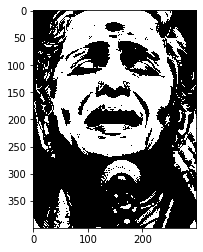

In [26]:
plt.imshow(MSS,'gray')
plt.show()

In [27]:
Digital_Signal = MSS.flatten()
print (Digital_Signal.shape)

(120000,)


## *Results*

In [0]:
fc = 2 * 1e6
T = 1e-6
M = 4
fs = 50 * 1e6
Cutoff_Freq = 25*pow(10,6)
Variance = np.array([20,12,7,5]).astype(int)
Ratio = np.array([-2,0,2,4,6]).astype(int)


(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Eb/No Ratio in dB is -2
Eb/No Ratio is 0.6309573444801932
Variance of WGN 79.24465962305567


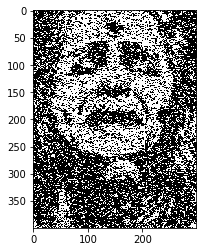

---------------------------------------------------------------------------------------
(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Eb/No Ratio in dB is 0
Eb/No Ratio is 1.0
Variance of WGN 50.0


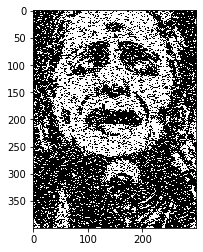

---------------------------------------------------------------------------------------
(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Eb/No Ratio in dB is 2
Eb/No Ratio is 1.5848931924611136
Variance of WGN 31.547867224009657


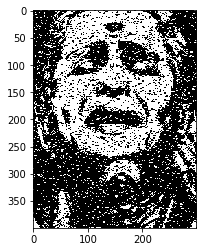

---------------------------------------------------------------------------------------
(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Eb/No Ratio in dB is 4
Eb/No Ratio is 2.51188643150958
Variance of WGN 19.905358527674863


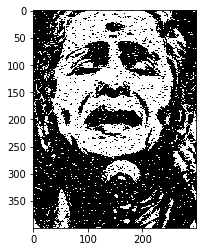

---------------------------------------------------------------------------------------
(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Eb/No Ratio in dB is 6
Eb/No Ratio is 3.9810717055349722
Variance of WGN 12.559432157547901


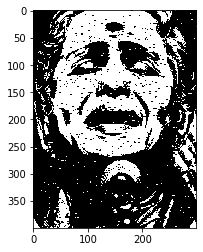

---------------------------------------------------------------------------------------


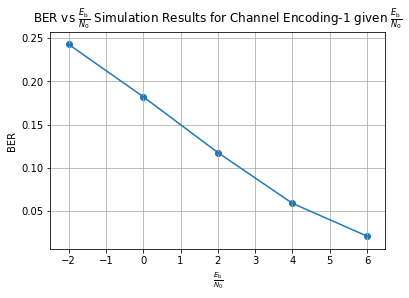

(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Variance of WGN 20
Eb/No Ratio is 2.5
Eb/No Ratio in dB is 3.979400086720376


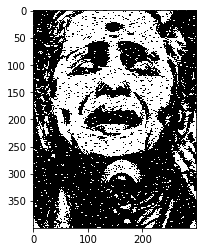

---------------------------------------------------------------------------------------
(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Variance of WGN 12
Eb/No Ratio is 4.166666666666667
Eb/No Ratio in dB is 6.19788758288394


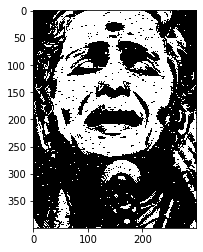

---------------------------------------------------------------------------------------
(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Variance of WGN 7
Eb/No Ratio is 7.142857142857142
Eb/No Ratio in dB is 8.53871964321762


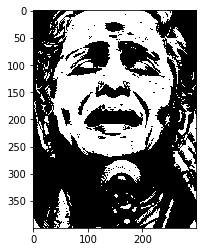

---------------------------------------------------------------------------------------
(120000, 50)
Average Energy of Transmitted Signal 8e-06
Energy per Bit of Transmitted Signal 2e-06
Variance of WGN 5
Eb/No Ratio is 10.0
Eb/No Ratio in dB is 10.0


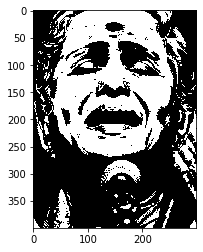

---------------------------------------------------------------------------------------


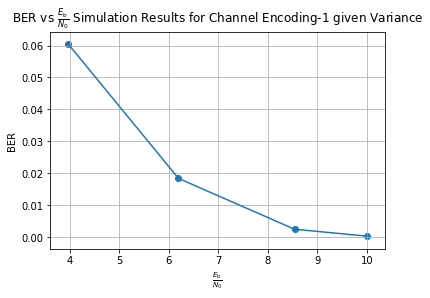

In [29]:
Variance = np.array([20,12,7,5]).astype(int)
Ratio = np.array([-2,0,2,4,6]).astype(int)

BER = []
Eb_per_No_dB = []

for r in Ratio:
    Encoded_Signal = Channel_EncodeTech1(Digital_Signal)
    Received_Signal,Ratio = Modulation(Encoded_Signal,fc,T,M,fs,8,4,Cutoff_Freq=Cutoff_Freq,Ratio=r)
    Bits_8,Bits_4 = Bit_Possibilities_Encoded(Digital_Signal,1)
    Decoded_Signal = Channel_DecodeTech1(Received_Signal,Bits_8,Bits_4)
    
    BER.append(Bit_Error_Rate(Decoded_Signal,Digital_Signal))
    Eb_per_No_dB.append(Ratio)
    
    Plot_Image(Decoded_Signal,shape)
    
Plot_BERGraph(Eb_per_No_dB,BER,r'Channel Encoding-1 given $\frac{E_{\mathrm{b}}}{N_{0}}$')


BER = []
Eb_per_No_dB = []

for v in Variance:
    Encoded_Signal = Channel_EncodeTech1(Digital_Signal)
    Received_Signal,Ratio = Modulation(Encoded_Signal,fc,T,M,fs,8,4,Cutoff_Freq=Cutoff_Freq,Variance=v,VarianceTruth=True)
    Bits_8,Bits_4 = Bit_Possibilities_Encoded(Digital_Signal,1)
    Decoded_Signal = Channel_DecodeTech1(Received_Signal,Bits_8,Bits_4)
    
    BER.append(Bit_Error_Rate(Decoded_Signal,Digital_Signal))
    Eb_per_No_dB.append(Ratio)
    
    Plot_Image(Decoded_Signal,shape)
    
Plot_BERGraph(Eb_per_No_dB,BER,'Channel Encoding-1 given Variance')

(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is -2
Eb/No Ratio is 0.6309573444801932
Variance of WGN 118.8669894345835


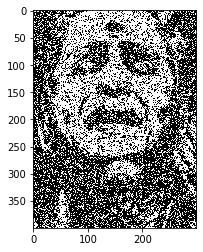

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 0
Eb/No Ratio is 1.0
Variance of WGN 75.0


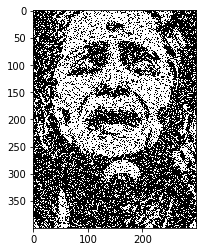

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 2
Eb/No Ratio is 1.5848931924611136
Variance of WGN 47.321800836014496


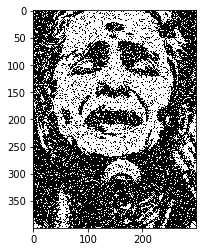

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 4
Eb/No Ratio is 2.51188643150958
Variance of WGN 29.85803779151229


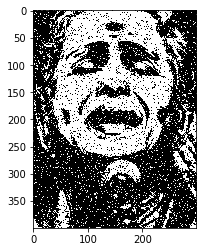

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 6
Eb/No Ratio is 3.9810717055349722
Variance of WGN 18.839148236321854


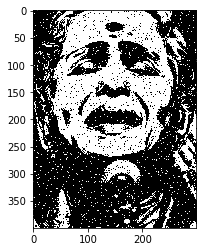

---------------------------------------------------------------------------------------


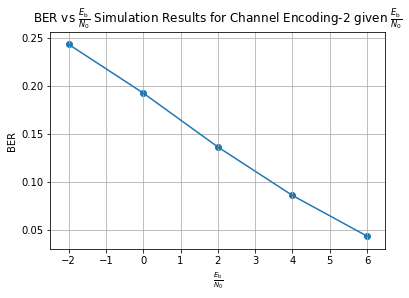

(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 20
Eb/No Ratio is 3.7500000000000004
Eb/No Ratio in dB is 5.740312677277188


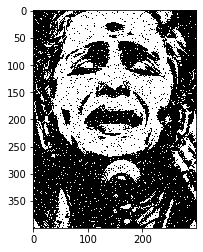

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 12
Eb/No Ratio is 6.250000000000001
Eb/No Ratio in dB is 7.958800173440752


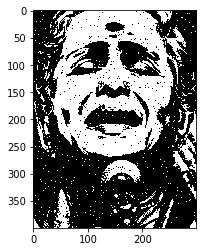

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 7
Eb/No Ratio is 10.714285714285714
Eb/No Ratio in dB is 10.299632233774432


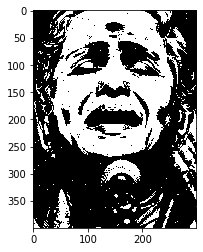

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 3e-06
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 5
Eb/No Ratio is 15.000000000000002
Eb/No Ratio in dB is 11.760912590556813


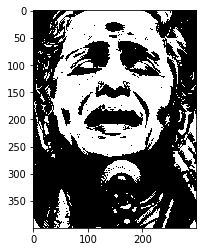

---------------------------------------------------------------------------------------


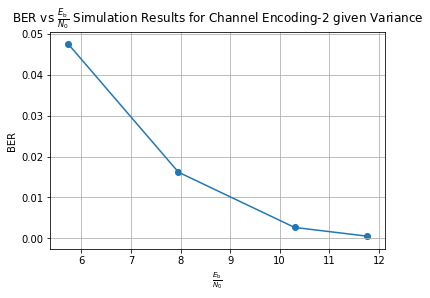

In [30]:
Variance = np.array([20,12,7,5]).astype(int)
Ratio = np.array([-2,0,2,4,6]).astype(int)

BER = []
Eb_per_No_dB = []
for r in Ratio:
    Encoded_Signal = Channel_EncodeTech2(Digital_Signal)
    Received_Signal,Ratio = Modulation(Encoded_Signal,fc,T,M,fs,3,1,Cutoff_Freq=Cutoff_Freq,Ratio=r)
    Decoded_Signal = Channel_DecodeTech2(Received_Signal)
    
    BER.append(Bit_Error_Rate(Decoded_Signal,Digital_Signal))
    Eb_per_No_dB.append(Ratio)
    
    Plot_Image(Decoded_Signal,shape)
    
Plot_BERGraph(Eb_per_No_dB,BER,r'Channel Encoding-2 given $\frac{E_{\mathrm{b}}}{N_{0}}$')


BER = []
Eb_per_No_dB = []

for v in Variance:
    Encoded_Signal = Channel_EncodeTech2(Digital_Signal)
    Received_Signal,Ratio = Modulation(Encoded_Signal,fc,T,M,fs,3,1,Cutoff_Freq=Cutoff_Freq,Variance=v,VarianceTruth=True)
    Decoded_Signal = Channel_DecodeTech2(Received_Signal)
    
    BER.append(Bit_Error_Rate(Decoded_Signal,Digital_Signal))
    Eb_per_No_dB.append(Ratio)
    
    Plot_Image(Decoded_Signal,shape)
    
Plot_BERGraph(Eb_per_No_dB,BER,'Channel Encoding-2 given Variance')

(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is -2
Eb/No Ratio is 0.6309573444801932
Variance of WGN 118.8669894345835


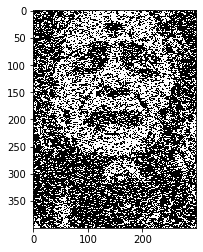

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 0
Eb/No Ratio is 1.0
Variance of WGN 75.0


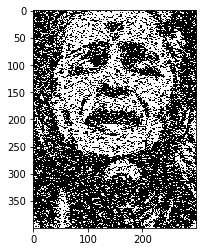

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 2
Eb/No Ratio is 1.5848931924611136
Variance of WGN 47.321800836014496


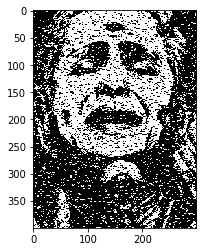

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 4
Eb/No Ratio is 2.51188643150958
Variance of WGN 29.85803779151229


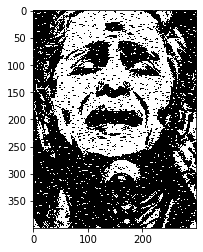

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Eb/No Ratio in dB is 6
Eb/No Ratio is 3.9810717055349722
Variance of WGN 18.839148236321854


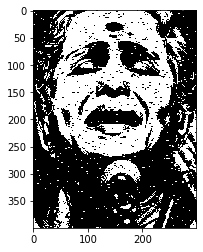

---------------------------------------------------------------------------------------


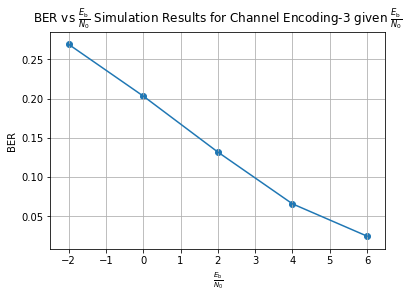

(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 20
Eb/No Ratio is 3.7500000000000004
Eb/No Ratio in dB is 5.740312677277188


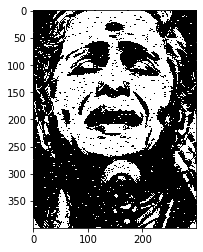

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 12
Eb/No Ratio is 6.250000000000001
Eb/No Ratio in dB is 7.958800173440752


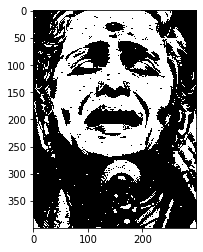

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 7
Eb/No Ratio is 10.714285714285714
Eb/No Ratio in dB is 10.299632233774432


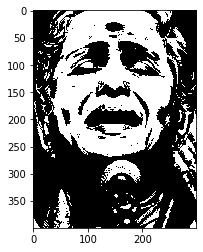

---------------------------------------------------------------------------------------
(180000, 50)
Average Energy of Transmitted Signal 1.2e-05
Energy per Bit of Transmitted Signal 3e-06
Variance of WGN 5
Eb/No Ratio is 15.000000000000002
Eb/No Ratio in dB is 11.760912590556813


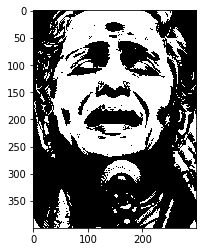

---------------------------------------------------------------------------------------


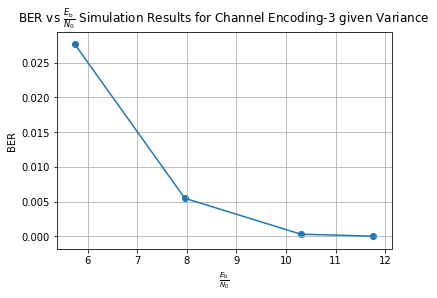

In [31]:
Variance = np.array([20,12,7,5]).astype(int)
Ratio = np.array([-2,0,2,4,6]).astype(int)

BER = []
Eb_per_No_dB = []
for r in Ratio:
    Encoded_Signal = Channel_EncodeTech3(Digital_Signal)
    Received_Signal,Ratio = Modulation(Encoded_Signal,fc,T,M,fs,12,4,Cutoff_Freq=Cutoff_Freq,Ratio=r)
    Bits_12,Bits_4 = Bit_Possibilities_Encoded(Digital_Signal,3)
    Decoded_Signal = Channel_DecodeTech3(Received_Signal,Bits_12,Bits_4)
    
    BER.append(Bit_Error_Rate(Decoded_Signal,Digital_Signal))
    Eb_per_No_dB.append(Ratio)
    
    Plot_Image(Decoded_Signal,shape)
    
Plot_BERGraph(Eb_per_No_dB,BER,r'Channel Encoding-3 given $\frac{E_{\mathrm{b}}}{N_{0}}$')


BER = []
Eb_per_No_dB = []

for v in Variance:
    Encoded_Signal = Channel_EncodeTech3(Digital_Signal)
    Received_Signal,Ratio = Modulation(Encoded_Signal,fc,T,M,fs,12,4,Cutoff_Freq=Cutoff_Freq,Variance=v,VarianceTruth=True)
    Bits_12,Bits_4 = Bit_Possibilities_Encoded(Digital_Signal,3)
    Decoded_Signal = Channel_DecodeTech3(Received_Signal,Bits_12,Bits_4)
    
    BER.append(Bit_Error_Rate(Decoded_Signal,Digital_Signal))
    Eb_per_No_dB.append(Ratio)
    
    Plot_Image(Decoded_Signal,shape)
    
Plot_BERGraph(Eb_per_No_dB,BER,'Channel Encoding-3 given Variance')

The Graphs shows us the results of Simulations. X-axis has $\frac{E_{\mathrm{b}}}{N_{0}}$ in decibal scale and Y-axis as BER(Bit Error Rate). We can observe that as $\frac{E_{\mathrm{b}}}{N_{0}}$ increases BER decreases.